### 목적: 슛 쏠 당시의 조건과 성공 여부와의 상관관계를 파악
### 분석 방법: 논리적 회귀 (Logistic Regression)
### 데이터셋: NBA shot logs (https://www.kaggle.com/datasets/dansbecker/nba-shot-logs)


- 데이터 개수: 121504개
- 변수 개수: 독립 변수 7개 / 종속 변수 1개
- 독립 변수 (슛 쏠 당시의 조건)
  - `PERIOD`: 슛이 시도되었을 때의 경기 쿼터 (중간에 병합함)
  - `GAME_CLOCK`: 슛이 시도되었을 때, 쿼터의 진행 시간 (중간에 병합함)
  - `SHOT_CLOCK`: 공격 제한 시간 24초가 주어질 때, 슛이 시도되었을 때 남은 시간
  - `DRIBBLES`: 공을 잡은 플레이어가 슛을 시도하기 전까지의 드리블 횟수
  - `TOUCH_TIME`: 공을 잡은 플레이어가 슛을 시도하기 전까지 공을 소유한 시간
  - `SHOT_DIST`: 슛이 시도되었을 때, 골대와의 거리
  - `CLOSE_DEF_DIST`: 슛이 시도되었을 때, 가장 가까운 수비수와의 거리
  - `PTS`: 몇 점 슛인지에 대한 데이터로, 0에서 3까지 구분 (중간에 제거함)
- 종속 변수 (`SHOT_RESULT`: 슛 성공 여부)
  - missed: 0, 실패 / made: 1, 성공

In [182]:
# 외부 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

### 1. 데이터 전처리

In [183]:
# Google Colab 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [184]:
# 데이터 불러오기
shot_logs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bd/data/shot_logs.csv')

shot_logs

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,5,3,1:52,18.3,5,...,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,6,4,11:28,19.8,4,...,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,7,4,11:10,23.0,2,...,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,8,4,2:37,9.1,4,...,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [185]:
# 결측치 확인
shot_logs.isnull().sum()

GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
player_name                      0
player_id                        0
dtype: int64

SHOT_CLOCK 변수에서 5442개의 결측치를 발견해, 해당하는 행을 전부 제거하기로 결정

In [186]:
# 결측치를 포함한 행 전부 제거
shot_logs = shot_logs.dropna(axis=0)

In [187]:
# 사용할 종속 변수와 독립 변수 빼고 제거
shot_logs = shot_logs.loc[:, ['SHOT_RESULT', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'PTS']]

shot_logs

,SHOT_RESULT,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,PTS
0,made,1,1:09,10.8,2,1.9,7.7,1.3,2
1,missed,1,0:14,3.4,0,0.8,28.2,6.1,0
3,missed,2,11:47,10.3,2,1.9,17.2,3.4,0
4,missed,2,10:34,10.9,2,2.7,3.7,1.1,0
5,missed,2,8:15,9.1,2,4.4,18.4,2.6,0
...,...,...,...,...,...,...,...,...,...
128063,made,2,5:05,15.3,2,1.6,8.9,5.7,2
128064,missed,3,1:52,18.3,5,6.2,8.7,0.8,0
128065,made,4,11:28,19.8,4,5.2,0.6,0.6,2
128066,made,4,11:10,23.0,2,4.2,16.9,4.2,2


In [188]:
# SHOT_RESULT의 made는 1로, missed는 0으로 치환
def parseResult(str):
  if str == "missed":
    return 0
  if str == "made":
    return 1
  
shot_logs["SHOT_RESULT"] = shot_logs["SHOT_RESULT"].map(parseResult)

shot_logs

,SHOT_RESULT,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,PTS
0,1,1,1:09,10.8,2,1.9,7.7,1.3,2
1,0,1,0:14,3.4,0,0.8,28.2,6.1,0
3,0,2,11:47,10.3,2,1.9,17.2,3.4,0
4,0,2,10:34,10.9,2,2.7,3.7,1.1,0
5,0,2,8:15,9.1,2,4.4,18.4,2.6,0
...,...,...,...,...,...,...,...,...,...
128063,1,2,5:05,15.3,2,1.6,8.9,5.7,2
128064,0,3,1:52,18.3,5,6.2,8.7,0.8,0
128065,1,4,11:28,19.8,4,5.2,0.6,0.6,2
128066,1,4,11:10,23.0,2,4.2,16.9,4.2,2


- 이 때, `GAME_CLOCK`은 쿼터당 진행 시간이고 `PERIOD`는 진행 쿼터이기 때문에, 전체 게임 진행 시간을 알기 위해 두 독립 변수를 병합해 초 단위로 변환한 `TIME` 변수를 만들기로 결정

- 추가로, 연장전(PERIOD 5 이상)은 표본이 적어 제거하기로 결정 


In [189]:
# PERIOD 5 이상의 행 삭제
shot_logs.drop(index = shot_logs[shot_logs['PERIOD'] > 4].index, inplace=True)

# GAME_CLOCK과 PERIOD를 TIME 변수로 병합
def parseTime(str):
  sec = datetime.strptime(str, '%M:%S').timetuple().tm_sec
  min = datetime.strptime(str, '%M:%S').timetuple().tm_min
  return min * 60 + sec

# 모든 변수가 0 ~ 100 사이의 값을 가지도록 정규화
shot_logs['TIME'] = ((shot_logs['PERIOD'] - 1) * 720 + shot_logs["GAME_CLOCK"].map(parseTime)) / 100
shot_logs = shot_logs.loc[:, ['SHOT_RESULT', 'TIME', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'PTS']]

shot_logs

,SHOT_RESULT,TIME,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,PTS
0,1,0.69,10.8,2,1.9,7.7,1.3,2
1,0,0.14,3.4,0,0.8,28.2,6.1,0
3,0,14.27,10.3,2,1.9,17.2,3.4,0
4,0,13.54,10.9,2,2.7,3.7,1.1,0
5,0,12.15,9.1,2,4.4,18.4,2.6,0
...,...,...,...,...,...,...,...,...
128063,1,10.25,15.3,2,1.6,8.9,5.7,2
128064,0,15.52,18.3,5,6.2,8.7,0.8,0
128065,1,28.48,19.8,4,5.2,0.6,0.6,2
128066,1,28.30,23.0,2,4.2,16.9,4.2,2


### 2. 논리적 회귀

- 로지스틱 회귀 모델 생성에 `Perfect separation detected, results not available" while building the Logistic Regression model` 오류 발생!
- 독립변수에 종속변수와 동일한 기준을 가지는 `PTS` 변수가 존재하기 때문 (0점인 경우 missed와 동일하고 1~3점은 made와 동일)
- 따라서 X에 `PTS` 변수를 제거하기로 결정

In [190]:
# 독립변수와 종속변수 분리
X = shot_logs.loc[:, ['TIME', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST']]
Y = shot_logs.loc[:, ['SHOT_RESULT']]

In [191]:
# intercept 추가
X = sm.add_constant(X, has_constant='add')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [192]:
# 학습 데이터, 테스트 데이터 분리
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=1234, stratify=Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(85052, 7) (36452, 7) (85052, 1) (36452, 1)


In [193]:
# 로지스틱 회귀 모델 생성
logit_m = sm.Logit(Y_train, X_train)
logit_m_train = logit_m.fit(method='powell') # powell, cg, bfgs, lbfgs

logit_m_train.summary()

Optimization terminated successfully.
         Current function value: 0.662349
         Iterations: 5
         Function evaluations: 422


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            SHOT_RESULT   No. Observations:                85052
Model:                          Logit   Df Residuals:                    85045
Method:                           MLE   Df Model:                            6
Date:                Thu, 08 Dec 2022   Pseudo R-squ.:                 0.03920
Time:                        06:12:24   Log-Likelihood:                -56334.
converged:                       True   LL-Null:                       -58633.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0489      0.029      1.700      0.089      -0.007       0.105
TIME              -0.0018      0.001     -2.080      0.037      -0.003      -0.000
SHOT_CLOCK         0.0187      0.001     14.462      0.000       0.016       0.021
DRIBBLES           0.0239      0.006      4.251      0.000       0.013       0.035
TOUCH_TIME        -0.0481      0.007     -7.281      0.000      -0.061      -0.035
SHOT_DIST         -0.0598      0.001    -58.116      0.000      -0.062      -0.058
CLOSE_DEF_DIST     0.1078      0.003     31.980      0.000       0.101       0.114
==================================================================================
"""

In [194]:
Y_predict = logit_m_train.predict(X_test)
print(Y_predict)

94451     0.599369
103151    0.540752
53231     0.551822
2432      0.460256
50932     0.570798
            ...   
105988    0.291141
19710     0.488575
44149     0.509815
73505     0.349636
43975     0.639994
Length: 36452, dtype: float64


### 3.추가 연구 (생략)

In [195]:
# 오차행렬(confusion matirx)를 통해 예측 성능 확인
# confusion_matrix(Y_test, Y_predict)

- 오류가 발생! `ValueError: Classification metrics can't handle a mix of binary and continuous targets`
- 실제 종속변수의 값(Y_test)은 0, 1로 이루어진 반면 예측된 종속변수의 값(Y_predict)은 0.97, 0.52, 0.04과 같은 0과 1에 사이의 값들 
- 즉, 각 관측대상의 예측이 확률로 되어있는 것이다.(연속형) 이를 0과 1로 판단해 나눠줘야 하는데 이 때 기준값을 주어야 하며 이를 `threshold`라고 함

In [196]:
# Y_predict를 threshold를 기준으로 0과 1로 나누어주는 함수 생성
def cut_off(y,threshold):
    Y = y.copy() # copy함수를 사용하여 이전의 y값이 변화지 않게 함
    Y[Y>threshold]=1
    Y[Y<=threshold]=0
    return(Y.astype(int))

Y_predict_t = cut_off(Y_predict,0.5)

# 오차행렬(confusion matirx)를 통해 예측 성능 확인
confusion_matrix(Y_test, Y_predict_t)

array([[14195,  5613],
       [ 8811,  7833]])

In [197]:
# 예측 성능 수치화

accuracy = accuracy_score(Y_test, Y_predict_t)
precision = precision_score(Y_test, Y_predict_t)
recall = recall_score(Y_test, Y_predict_t)
f1 = f1_score(Y_test, Y_predict_t)
print('Accuracy : {0:.3f}'.format(accuracy))
print('Precision : {0:.3f}'.format(precision))
print('Recall : {0:.3f}'.format(recall))
print('F1 : {0:.3f}'.format(f1))

Accuracy : 0.604
Precision : 0.583
Recall : 0.471
F1 : 0.521


임계값이 몇일때 가장 성능이 좋아지는지 비교해보기로 결정

In [198]:
# 임계값에 따른 비교
def perf_eval(cm):
    # Accuracy
    Accuracy = (cm[0, 0] + cm[1, 1]) / sum(cm.reshape(-1, ))
    # Precision
    Precision = cm[1, 1] /sum(cm[:, 1])
    # Recall
    Recall = cm[1, 1] / sum(cm[1])
    # F1-score
    F1 = 2 * Recall * Precision / (Recall + Precision)
    return ([Accuracy, Precision, Recall, F1])

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
for i in threshold:
    Y_predict_temp = cut_off(Y_predict,i)
    confusion_matrix_temp = confusion_matrix(Y_test, Y_predict_temp)
    table.loc[i] = perf_eval(confusion_matrix_temp)
table.index.name='threshold'
table.columns.name='performance'
print(table)

performance  Accuracy  Precision    Recall        F1
threshold                                           
0.0          0.456600   0.456600  1.000000  0.626940
0.1          0.456628   0.456613  1.000000  0.626952
0.2          0.457670   0.457040  0.998738  0.627106
0.3          0.487408   0.469600  0.947128  0.627885
0.4          0.554757   0.508812  0.718157  0.595625
0.5          0.604302   0.582552  0.470620  0.520638
0.6          0.591243   0.712062  0.175919  0.282135
0.7          0.551684   0.879397  0.021029  0.041075
0.8          0.545649   0.965909  0.005107  0.010160
0.9          0.544168   1.000000  0.001682  0.003359


대략 0.5 정도로 추정, 정확한 수치 탐색 및 시각화

Train Accuracy: 0.6083454827634859 
Train AUC: 0.5960908746935123 
Train Confusion Matrix:
[[34075 12142]
 [21169 17666]]
Test Accuracy: 0.6060847141446285 
Test AUC: 0.5942051201750698 
Test Confusion Matrix:
[[14481  5327]
 [ 9032  7612]]


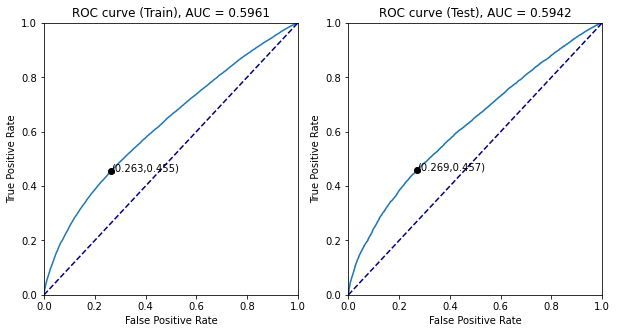

Best Threshold: 0.5051507736820764


In [199]:
def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label =True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
    print('Train Confusion Matrix:')
    print(cm_train)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)
    plt.show()

    return best_threshold

best_threshold = plot_ROC(y_train_true=Y_train, y_train_prob=logit_m_train.predict(X_train), 
                          y_test_true=Y_test, y_test_prob=logit_m_train.predict(X_test))
print('Best Threshold:', best_threshold)

임계값에 따라 나올 수 있는 가장 높은 정확도

In [200]:
Y_predict_t = cut_off(Y_predict,0.5051572211823533)

accuracy = accuracy_score(Y_test, Y_predict_t)
precision = precision_score(Y_test, Y_predict_t)
recall = recall_score(Y_test, Y_predict_t)
f1 = f1_score(Y_test, Y_predict_t)
print('Accuracy : {0:.3f}'.format(accuracy))
print('Precision : {0:.3f}'.format(precision))
print('Recall : {0:.3f}'.format(recall))
print('F1 : {0:.3f}'.format(f1))

Accuracy : 0.606
Precision : 0.588
Recall : 0.457
F1 : 0.515


### 4.결론

In [201]:
logit_m_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            SHOT_RESULT   No. Observations:                85052
Model:                          Logit   Df Residuals:                    85045
Method:                           MLE   Df Model:                            6
Date:                Thu, 08 Dec 2022   Pseudo R-squ.:                 0.03920
Time:                        06:12:27   Log-Likelihood:                -56334.
converged:                       True   LL-Null:                       -58633.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0489      0.029      1.700      0.089      -0.007       0.105
TIME              -0.0018      0.001     -2.080      0.037      -0.003      -0.000
SHOT_CLOCK         0.0187      0.001     14.462      0.000       0.016       0.021
DRIBBLES           0.0239      0.006      4.251      0.000       0.013       0.035
TOUCH_TIME        -0.0481      0.007     -7.281      0.000      -0.061      -0.035
SHOT_DIST         -0.0598      0.001    -58.116      0.000      -0.062      -0.058
CLOSE_DEF_DIST     0.1078      0.003     31.980      0.000       0.101       0.114
==================================================================================
"""

회귀 분석 결과에 대한 결론
1. `P value 값`은 대부분 0에 수렴하고 `TIME` 변수의 경우 `0.038`이지만 `0.05` 이하는 유의미하다고 판단, 즉 모든 독립 변수가 유의미
2. `coef 값`이 양수인 경우 수치가 높을 수록 슛 성공에 유리한 조건, 음수인 경우 수치가 낮을 수록 슛 성공에 유리한 조건

각 변수에 대한 분석 (영향 높은 순으로 정렬)
- `CLOSE_DEF_DIS`: 가장 가까운 수비수와의 거리가 멀수록 슛 성공률이 높아짐
- `SHOT_DIST`: 골대와의 거리가 가까울 수록 슛 성공률이 높아짐
- `TOUCH_TIME`: 공을 잡은 플레이어가 공을 소유한 시간이 짧을 수록 (= 공을 잡고 슛을 빨리 쏠 수록) 슛 성공률이 높아짐
- `DRIBBLES`: 드리블 횟수가 많을 수록 슛 성공률이 높아짐
- `SHOT_CLOCK`: 공격 제한 시간이 많이 남았을 때 슛 성공률이 높아짐
- `TIME`: 경기가 초반부일 수록 슛 성공률이 높아짐